# XBRL Reader para fondos españoles

El objetivo de este notebook es desarrollar un parser de documentos XBRL remitidos a la CNMV por fondos de inversión en España.

## Table of contents

* Libraries import 
* XBRL document import

## Libraries import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import lxml
from lxml import etree
import datetime as dt
import matplotlib.pyplot as plt

## XBRL document import

Comment and uncomment accordingly

In [2]:
tree = etree.parse('../data/az_valor_iberia_H1_17.XML')
tree = etree.parse('../data/bestinver_iberia_H1_17.XML')
tree = etree.parse('../data/cobas_iberia_H1_17.XML')

root = tree.getroot()
gestora = 'AZ VALOR'
fondo = 'AZ VALOR IBERIA'

gestora = 'BESTINVER'
fondo = 'BESTINVER BOLSA'

gestora = 'COBAS'
fondo = 'COBAS IBERIA'

In [3]:
import xml.etree.ElementTree as ET

In [4]:
tree = ET.parse('../data/az_valor_iberia_H1_17.XML')
root = tree.getroot()

In [8]:
import untangle
obj = untangle.parse('../data/az_valor_iberia_H1_17.XML')

In [18]:
a = obj.xbrli_xbrl.xbrli_context[0]

In [77]:
companies = obj.xbrli_xbrl.iic_fim_InformeFIM.iic_fim_DatosFondoCompartimentoFIM.iic_fim_InversionesFinancierasFIM.iic_com_InversionesFinancierasValorEstimado.iic_com_InversionesFinancierasInterior.iic_com_InversionesFinancierasRVCotizada

In [79]:
a,  b = None, None

In [76]:
for c in companies:
    for b in c.iic_com_InversionesFinancierasImporte:
        element = b.iic_com_InversionesFinancierasPorcentaje
        value = b.iic_com_InversionesFinancierasValor
        
        print(element.get_attribute('contextRef'))
        if element.get_attribute('contextRef').endswith('ia'):
            print(element.cdata)

FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
2.88
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
2.47
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
2.55
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.40
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
1.42
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
8.23
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
3.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.27
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
3.45
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
4.29
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
0.00
FIM_S12017_V-87393237_ipy
FIM_S12017_V-87393237_ia
3.64
FIM_S12017_V-87393

In [43]:
a.iic_com_InversionesFinancierasPorcentaje

Element(name = iic_com_InversionesFinancierasPorcentaje, attributes = {'unitRef': 'pure', 'decimals': '2', 'contextRef': 'FIM_S12017_V-87393237_ipy'}, cdata = 1.63)

In [48]:
comp[0]

Element(name = iic_com_InversionesFinancierasRVCotizada, attributes = {}, cdata = 





)

## Get dates

In [13]:
class XBRLParser(object):
    
    STOCK_KEY = "{http://www.cnmv.es/iic/com/1-2009/2009-03-31}"
    KEY_CTX = "{http://www.xbrl.org/2003/instance}"
    
    def __init__(self, management, fund_name, xbrl_file):
        """
        * management: Fund management company e.g. AZ Valor, Cobas...
        * fund_name: Fund name
        * xbrl_file: Path to the XBRL file to parse.
        """
        self.management = management
        self.fund_name = fund_name
        self.xbrl_file = xbrl_file

    def set_root(self):
        """Open the XBRL file with lxml
        """
        tree = etree.parse(self.xbrl_file)
        self.root = tree.getroot()
        
    def set_dates(self):
        """Get initial and final dates of the period
        """
        context = self.root.find("" + self.KEY_CTX + "context")
        start_date_str = context.getchildren()[1].getchildren()[0].text
        end_date_str = context.getchildren()[1].getchildren()[1].text
        self.start_date = dt.datetime.strptime(start_date_str, "%Y-%m-%d")
        self.end_date = dt.datetime.strptime(end_date_str, "%Y-%m-%d")
       
    def parse_stocks(self):
        """Parse stocks
        """
        stocks = self.root.findall(".//" + self.STOCK_KEY + "InversionesFinancierasRVCotizada")
    
        pandas_list = []

        for stock in stocks:
            dict_aux = {}
    
            # Meta information
            dict_aux['CodigoISIN'] = stock.find(self.STOCK_KEY + "CodigoISIN").text
            dict_aux['Name'] = stock.find(self.STOCK_KEY + "InversionesFinancierasDescripcion").text.split("|")[1]

        
            importes = stock.findall(self.STOCK_KEY + "InversionesFinancierasImporte")
            t_key = importes[0].find(self.STOCK_KEY + "InversionesFinancierasValor").get('contextRef')
            if t_key.endswith('ia'):
                current = importes[0]
                try:
                    before = importes[1]
                except:
                    before = None   
            else:
                before = importes[0]
                try:
                    current = importes[1]
                except:
                    current = None
    
            # Importes
            try:
                dict_aux['Importe_0'] = float(before.find(self.STOCK_KEY + "InversionesFinancierasValor").text)
                dict_aux['Percent_0'] = float(before.find(self.STOCK_KEY + "InversionesFinancierasPorcentaje").text)
            except:
                dict_aux['Importe_0'] = 0.0
                dict_aux['Percent_0'] = 0.0
        
            try:
                dict_aux['Importe_1'] = float(current.find(self.STOCK_KEY + "InversionesFinancierasValor").text)
                dict_aux['Percent_1'] = float(current.find(self.STOCK_KEY + "InversionesFinancierasPorcentaje").text)
            except:
                dict_aux['Importe_1'] = 0.0
                dict_aux['Percent_1'] = 0.0
    
            # Additional information
            dict_aux['start_date'] = self.start_date
            dict_aux['end_date'] = self.end_date
            dict_aux['fund'] = self.fund_name
            dict_aux['manager'] =  self.management
    
            pandas_list.append(dict_aux)
            self.df = pd.DataFrame(pandas_list)
        return self.df
    
    def parse_xbrl(self):
        """Pipeline method
        """
        self.set_root()
        self.set_dates()
        df = self.parse_stocks()
        return df

In [19]:
cobas = XBRLParser('COBAS', 'COBAS IBERIA', './data/cobas_iberia_H1_17.XML')
df1 = cobas.parse_xbrl()

azvalor = XBRLParser('AZ Valor', 'AZ Valor IBERIA', './data/az_valor_iberia_H1_17.XML')
df2 = azvalor.parse_xbrl()

bestinver = XBRLParser('Bestinver', 'Bestinver Bolsa', './data/bestinver_iberia_H1_17.XML')
df3 = bestinver.parse_xbrl()

## CONCAT ALL funds
df = pd.concat([df1, df2, df3])

In [41]:
def plot_fund_dist(fund_name, df):
    fig = plt.figure(figsize=(15,10))
    select = df[df['fund']==fund_name][['Percent_1', 'Percent_0', 'Name']].sort_values('Percent_1', ascending=False)
    ind = np.arange(select.shape[0])
    
    width = 0.35
    
    p1 = plt.bar(ind, select['Percent_1'], width)
    p2 = plt.bar(ind+width, select['Percent_0'], width)

    plt.ylabel('PCT in fund', fontsize=14)
    plt.xticks(ind+width, select['Name'], rotation=90, fontsize=12)
    plt.title(fund_name, fontsize=14)
    plt.grid()
    plt.legend(('EoP','BoP'))


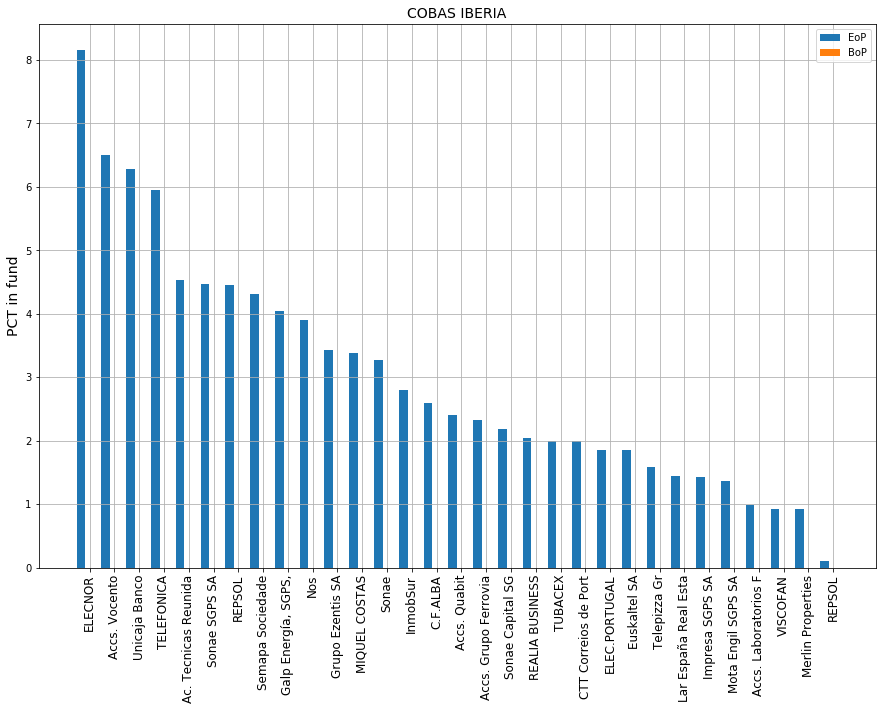

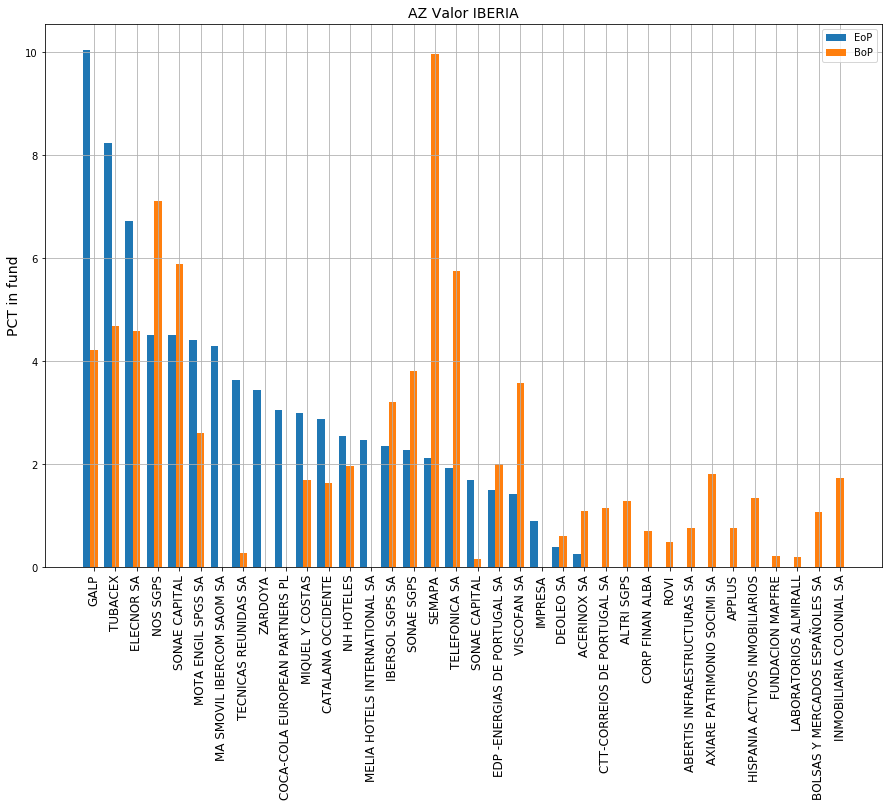

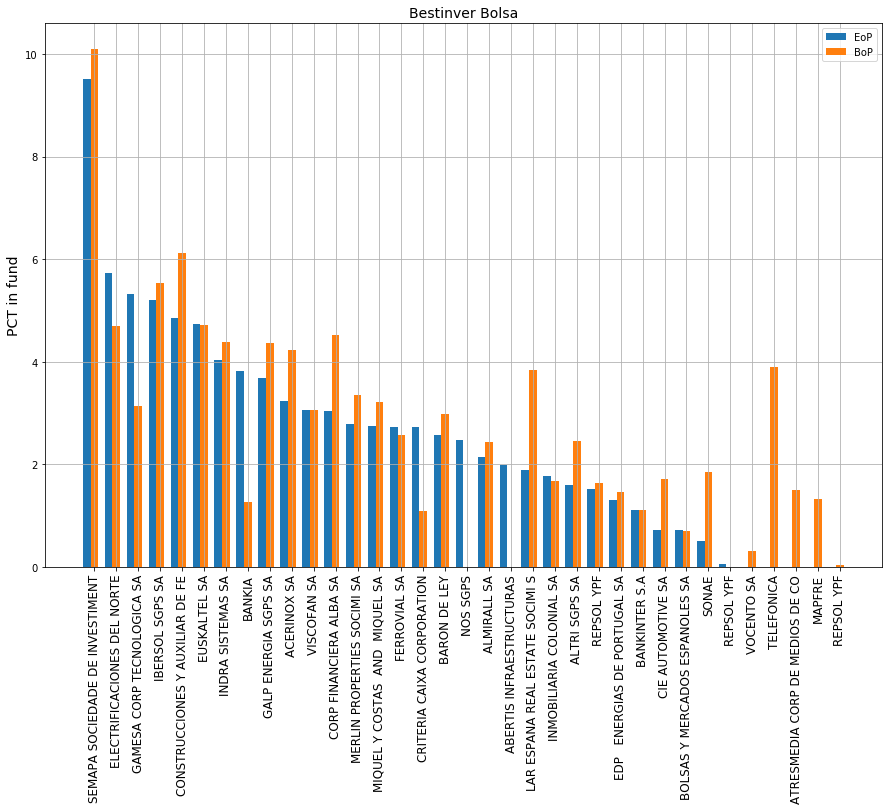

In [42]:
plot_fund_dist('COBAS IBERIA', df)
plot_fund_dist('AZ Valor IBERIA', df)
plot_fund_dist('Bestinver Bolsa', df)